In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model import from_student_number_to_naca, add_zeros
from tqdm import tqdm as tqdm

from pathlib import Path

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

Fixed geometry parametrization for both airfoils. 

In [5]:
NUM_POINTS_X = 50

In [25]:
ALPHA_0 = -15
ALPHA_N =  15
N = 10
ALPHAS = np.linspace(ALPHA_0, ALPHA_N, N)
ALPHAS = np.insert(ALPHAS, 0, 0.0)
ALPHAS = np.sort(ALPHAS)

In [ ]:
path_data = Path('../data/comparison_camber')

### Create solver methods

In [26]:
ITERATIONS_MAX     = 1e4
ITERATIONS_RESTART = ITERATIONS_MAX
%run 2-Solver.ipynb

In [27]:
naca1, naca2 = '0007', '2407'

In [28]:
print(f'1st NACA = {naca1}', f'2nd NACA = {naca2}', sep = '\n')

1st NACA = 0007
2nd NACA = 2407


## Solve for the first airfoil

### NACA-0007

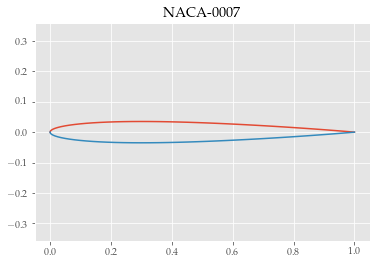

100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


In [29]:
NACA = naca1
%run 1-Geometry.ipynb

x_naca1, y_naca1 = x_c, y_c
normals_naca1    = normals

data_naca1_cp = []
data_naca1_cl = []

for alpha in tqdm(ALPHAS):
    
    _, cp, cl = solve(alpha)
    
    data_naca1_cp.append((alpha, cp))
    data_naca1_cl.append((alpha, cl))

### NACA-2407

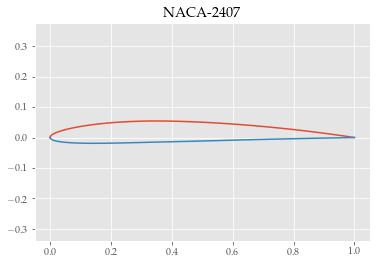

100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


In [30]:
NACA = naca2
%run 1-Geometry.ipynb

x_naca2, y_naca2 = x_c, y_c
normals_naca2    = normals

data_naca2_cp = []
data_naca2_cl = []

for alpha in tqdm(ALPHAS):
    
    _, cp, cl = solve(alpha)
    
    data_naca2_cp.append((alpha, cp))
    data_naca2_cl.append((alpha, cl))

## Lift comparison

In [31]:
cl_naca1_df = pd.DataFrame(data_naca1_cl, columns=['alpha', f'{naca1}-cl'])
cl_naca1_df = cl_naca1_df.set_index('alpha')

In [32]:
cl_naca2_df = pd.DataFrame(data_naca2_cl, columns=['alpha', f'{naca2}-cl'])
cl_naca2_df = cl_naca2_df.set_index('alpha')

In [33]:
cl_data_df = pd.DataFrame()

cl_data_df[f'{naca1}'] = cl_naca1_df[f'{naca1}-cl']

cl_data_df[f'{naca2}'] = cl_naca2_df[f'{naca2}-cl']

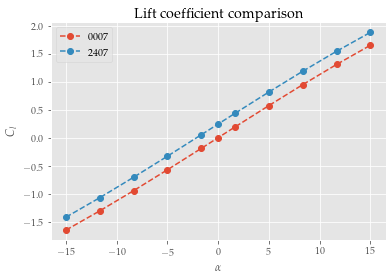

In [35]:
ax = cl_data_df.plot(linestyle = '--', marker = 'o')

ax.set(title  = f'Lift coefficient comparison', 
       xlabel = '$\\alpha$', 
       ylabel = '$C_l$')

plt.savefig(path_data / 'cl_comparison.png', 
            transparent = False, 
            bbox_inches = 'tight', dpi = 300)

In [79]:
_cl_data_df = cl_data_df.copy()

_cl_data_df.index =np.round(_cl_data_df.index, 2)

print(_cl_data_df.round(5).to_latex())

\begin{tabular}{lrr}
\toprule
{} &     0007 &     2407 \\
alpha  &          &          \\
\midrule
-15.00 & -1.64905 & -1.41894 \\
-11.67 & -1.30631 & -1.07093 \\
-8.33  & -0.94590 & -0.70651 \\
-5.00  & -0.57271 & -0.33061 \\
-1.67  & -0.19177 &  0.05169 \\
 0.00  &  0.00000 &  0.24362 \\
 1.67  &  0.19177 &  0.43521 \\
 5.00  &  0.57271 &  0.81478 \\
 8.33  &  0.94590 &  1.18525 \\
 11.67 &  1.30631 &  1.54162 \\
 15.00 &  1.64905 &  1.87908 \\
\bottomrule
\end{tabular}



### Pressure distribution comparison

In [36]:
cp_naca1_df = pd.DataFrame(index = x_naca1)

for element in data_naca1_cp:
    
    alpha, cp = element
    
    cp_naca1_df[alpha] = pd.Series(cp, index = x_naca1)

In [37]:
cp_naca2_df = pd.DataFrame(index = x_naca2)

for element in data_naca2_cp:
    
    alpha, cp = element
    
    cp_naca2_df[alpha] = pd.Series(cp, index = x_naca2)

In [42]:
ALPHAS == 0.0

array([False, False, False, False, False,  True, False, False, False,
       False, False])

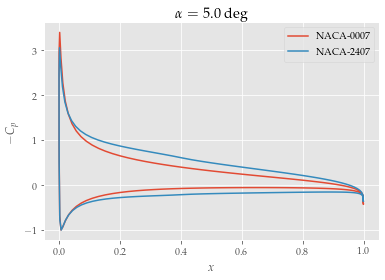

In [71]:
_alpha = ALPHAS[-4]
# _alpha = 0.0

cp_naca1_df[_alpha].mul(-1).plot(label = f'NACA-{naca1}')
cp_naca2_df[_alpha].mul(-1).plot(label = f'NACA-{naca2}')

plt.legend()
plt.title(f'$\\alpha = {np.round(_alpha, 2)}$ deg')
plt.ylabel('$-C_p$')
plt.xlabel('$x$')

plt.savefig(path_data / 'cp_comparison.png', 
            transparent = False, 
            bbox_inches = 'tight', dpi = 300)

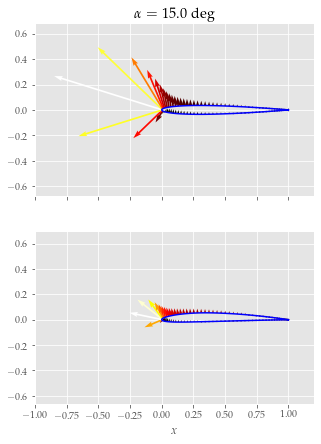

In [65]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize = (5, 7), sharex=True)


_scale = 30
_alpha = ALPHAS[-1]
# _alpha = 0.0

cp = cp_naca1_df[_alpha].values

axes[0].plot(x_naca1, y_naca1, c = 'b')
axes[0].quiver(x_naca1, 
           y_naca1, 
           -cp * normals_naca1[:,0], 
           -cp * normals_naca1[:,1], 
           -cp, cmap = 'hot',
          angles='xy', scale_units='xy', scale=_scale)
axes[0].axis('equal')
axes[0].set_title(f'$\\alpha = {np.round(_alpha, 2)}$ deg')
axes[0].set_xlim([-1,1.2])

_alpha = ALPHAS[-3]

cp = cp_naca2_df[_alpha].values

axes[1].plot(x_naca2, y_naca2, c = 'b')
axes[1].quiver(x_naca2, 
           y_naca2, 
           -cp * normals_naca2[:,0], 
           -cp * normals_naca2[:,1], 
           -cp, cmap = 'hot',
          angles='xy', scale_units='xy', scale=_scale)
axes[1].axis('equal')
axes[1].set(xlabel = '$x$')
axes[1].set_xlim([-1,1.2])

plt.savefig(path_data / 'cp_comparison_normals.png', 
            transparent = False, 
            bbox_inches = 'tight', dpi = 300)